# Conversational agent

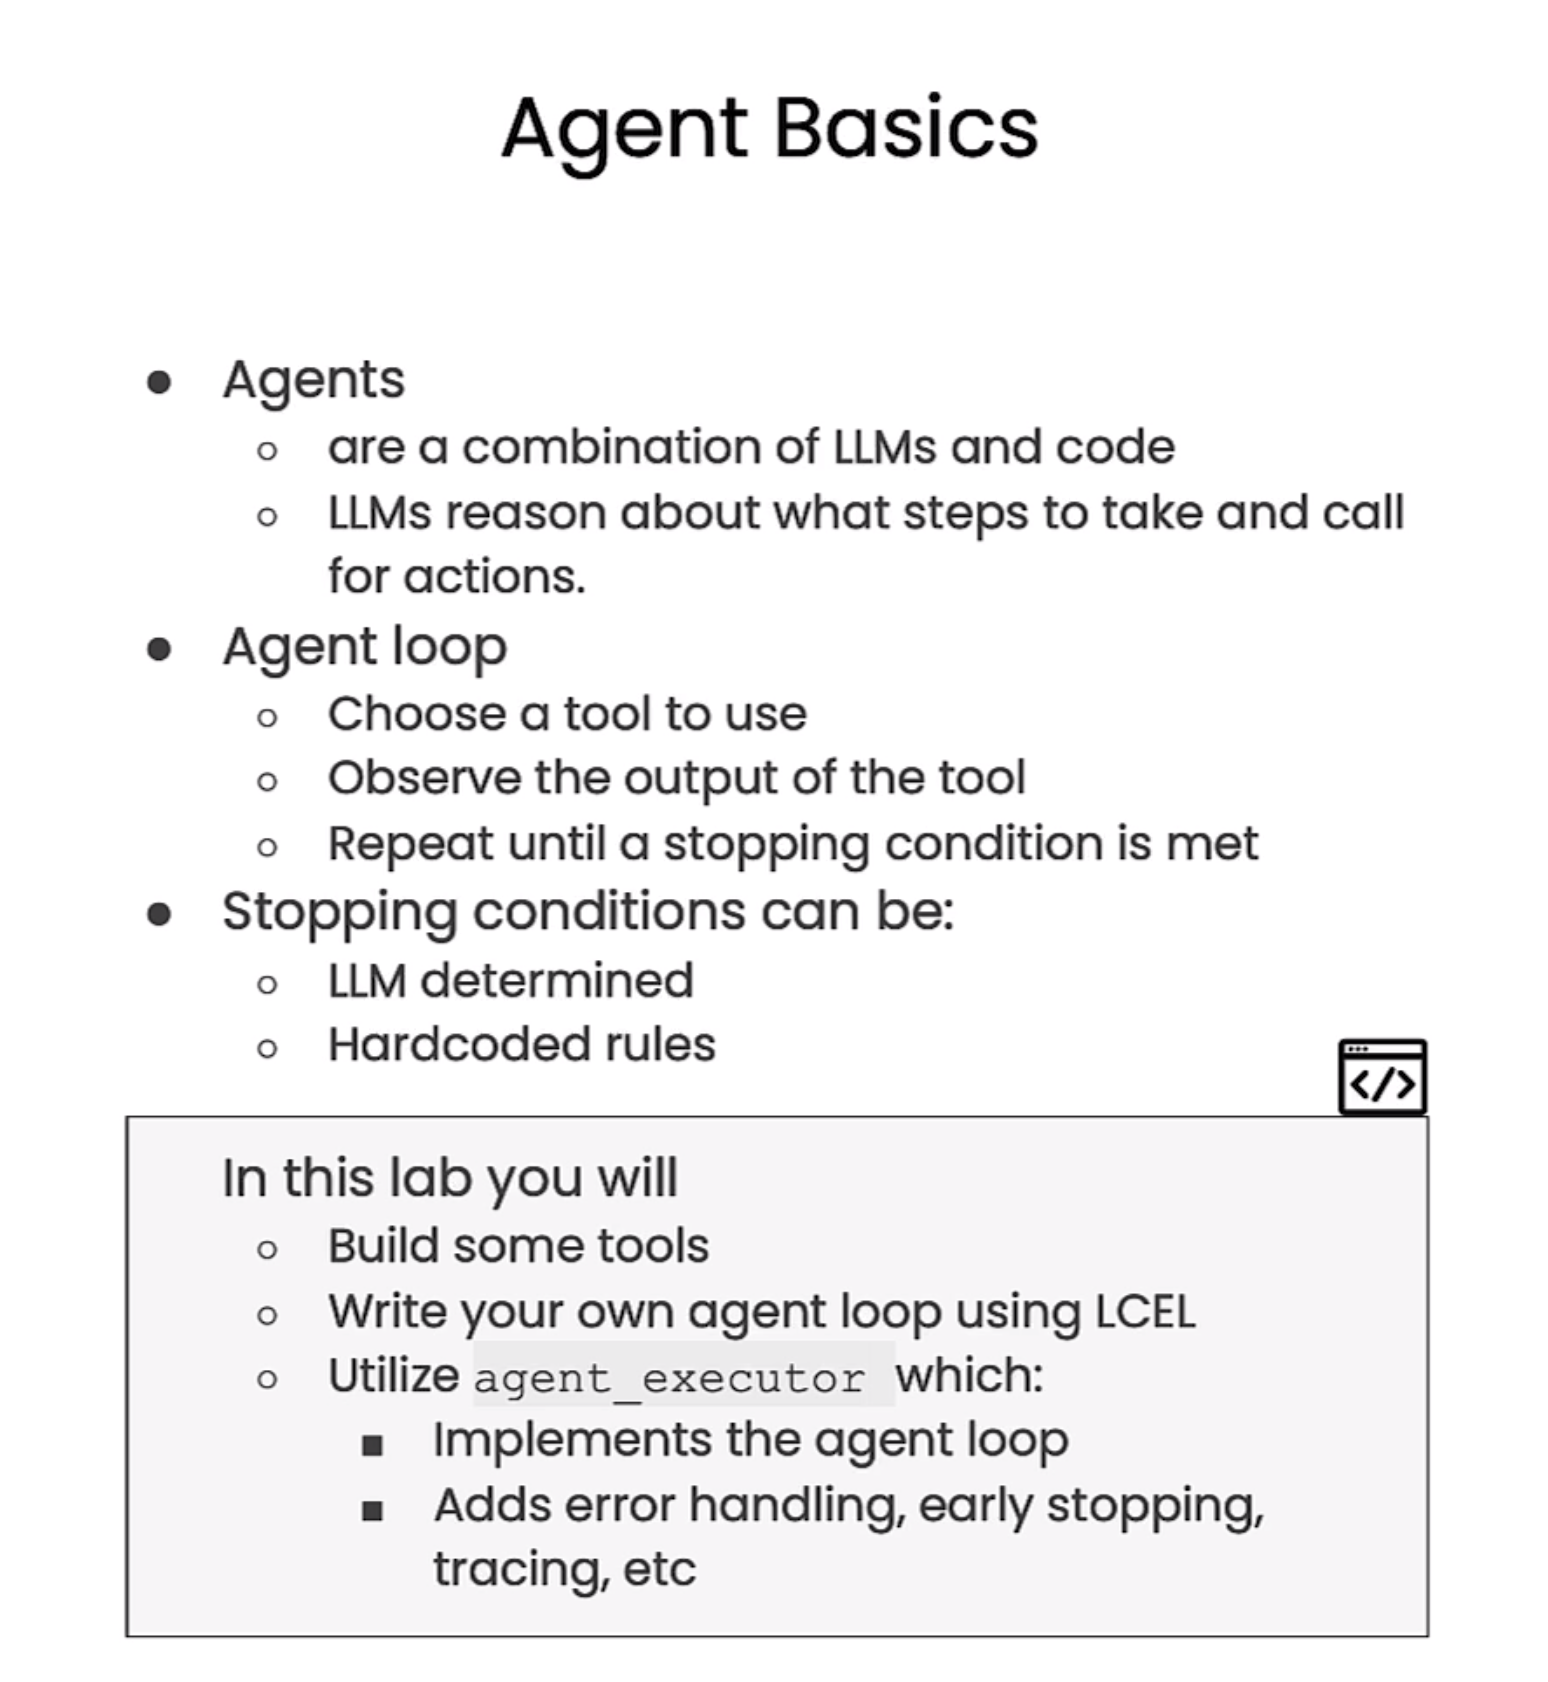

In [1]:
import os
import openai

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

In [2]:
from langchain.tools import tool

In [3]:
import requests
from pydantic import BaseModel, Field
import datetime

# Define the input schema
class OpenMeteoInput(BaseModel):
    latitude: float = Field(..., description="Latitude of the location to fetch weather data for")
    longitude: float = Field(..., description="Longitude of the location to fetch weather data for")

@tool(args_schema=OpenMeteoInput)
def get_current_temperature(latitude: float, longitude: float) -> dict:
    """Fetch current temperature for given coordinates."""
    
    BASE_URL = "https://api.open-meteo.com/v1/forecast"
    
    # Parameters for the request
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'hourly': 'temperature_2m',
        'forecast_days': 1,
    }

    # Make the request
    response = requests.get(BASE_URL, params=params)
    
    if response.status_code == 200:
        results = response.json()
    else:
        raise Exception(f"API Request failed with status code: {response.status_code}")

    current_utc_time = datetime.datetime.utcnow()
    time_list = [datetime.datetime.fromisoformat(time_str.replace('Z', '+00:00')) for time_str in results['hourly']['time']]
    temperature_list = results['hourly']['temperature_2m']
    
    closest_time_index = min(range(len(time_list)), key=lambda i: abs(time_list[i] - current_utc_time))
    current_temperature = temperature_list[closest_time_index]
    
    return f'The current temperature is {current_temperature}°C'

In [4]:
import wikipedia

@tool
def search_wikipedia(query: str) -> str:
    """Run Wikipedia search and get page summaries."""
    page_titles = wikipedia.search(query)
    summaries = []
    for page_title in page_titles[: 3]:
        try:
            wiki_page =  wikipedia.page(title=page_title, auto_suggest=False)
            summaries.append(f"Page: {page_title}\nSummary: {wiki_page.summary}")
        except (
            self.wiki_client.exceptions.PageError,
            self.wiki_client.exceptions.DisambiguationError,
        ):
            pass
    if not summaries:
        return "No good Wikipedia Search Result was found"
    return "\n\n".join(summaries)

In [5]:
tools = [get_current_temperature, search_wikipedia]

In [6]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.tools.render import format_tool_to_openai_function
from langchain.agents.output_parsers import OpenAIFunctionsAgentOutputParser

In [7]:
functions = [format_tool_to_openai_function(f) for f in tools]
model = ChatOpenAI(temperature=0).bind(functions=functions)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
])
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [8]:
result = chain.invoke({"input": "what is the weather is sf?"})

In [9]:
result.tool

'get_current_temperature'

In [10]:
result.tool_input

{'latitude': 37.7749, 'longitude': -122.4194}

In [11]:
from langchain.prompts import MessagesPlaceholder
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [12]:
chain = prompt | model | OpenAIFunctionsAgentOutputParser()

In [13]:
result1 = chain.invoke({
    "input": "what is the weather is sf?",
    "agent_scratchpad": []
})

In [14]:
result1.tool

'get_current_temperature'

In [15]:
observation = get_current_temperature(result1.tool_input)

In [16]:
observation

'The current temperature is 8.3°C'

In [17]:
type(result1)

langchain.schema.agent.AgentActionMessageLog

In [18]:
from langchain.agents.format_scratchpad import format_to_openai_functions

In [19]:
result1.message_log

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}'}})]

In [20]:
format_to_openai_functions([(result1, observation), ])

[AIMessage(content='', additional_kwargs={'function_call': {'name': 'get_current_temperature', 'arguments': '{\n  "latitude": 37.7749,\n  "longitude": -122.4194\n}'}}),
 FunctionMessage(content='The current temperature is 8.3°C', name='get_current_temperature')]

In [21]:
result2 = chain.invoke({
    "input": "what is the weather is sf?", 
    "agent_scratchpad": format_to_openai_functions([(result1, observation)])
})

In [22]:
result2

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 8.3°C.'}, log='The current temperature in San Francisco is 8.3°C.')

In [23]:
from langchain.schema.agent import AgentFinish
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = chain.invoke({
            "input": user_input, 
            "agent_scratchpad": format_to_openai_functions(intermediate_steps)
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [24]:
from langchain.schema.runnable import RunnablePassthrough
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | chain

In [25]:
def run_agent(user_input):
    intermediate_steps = []
    while True:
        result = agent_chain.invoke({
            "input": user_input, 
            "intermediate_steps": intermediate_steps
        })
        if isinstance(result, AgentFinish):
            return result
        tool = {
            "search_wikipedia": search_wikipedia, 
            "get_current_temperature": get_current_temperature,
        }[result.tool]
        observation = tool.run(result.tool_input)
        intermediate_steps.append((result, observation))

In [26]:
run_agent("what is the weather is sf?")

AgentFinish(return_values={'output': 'The current temperature in San Francisco is 8.3°C.'}, log='The current temperature in San Francisco is 8.3°C.')

In [27]:
run_agent("what is langchain?")

AgentFinish(return_values={'output': 'I couldn\'t find specific information about "LangChain" in my search results. It\'s possible that LangChain is a term or concept that is not widely known or documented. If you have any additional information or context about LangChain, I may be able to provide more assistance.'}, log='I couldn\'t find specific information about "LangChain" in my search results. It\'s possible that LangChain is a term or concept that is not widely known or documented. If you have any additional information or context about LangChain, I may be able to provide more assistance.')

In [28]:
run_agent("hi!")

AgentFinish(return_values={'output': 'Hello! How can I assist you today?'}, log='Hello! How can I assist you today?')

In [29]:
from langchain.agents import AgentExecutor
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True)

In [30]:
agent_executor.invoke({"input": "what is langchain?"})



> Entering new AgentExecutor chain...

Invoking: `search_wikipedia` with `{'query': 'langchain'}`


Page: LangChain
Summary: LangChain is a framework designed to simplify the creation of applications using large language models (LLMs). As a language model integration framework, LangChain's use-cases largely overlap with those of language models in general, including document analysis and summarization, chatbots, and code analysis.

Page: OpenAI
Summary: OpenAI is a U.S. artificial intelligence (AI) research organization founded in December 2015, researching artificial intelligence with the declared intention of developing "safe and beneficial" artificial general intelligence, which it defines as "highly autonomous systems that outperform humans at most economically valuable work".
As one of the leading organizations of the AI Spring, it has developed several large language models, advanced image generation models, and previously, also open-source models. Its release of ChatGPT has be

{'input': 'what is langchain?',
 'output': 'I couldn\'t find specific information about "LangChain" in my search results. It\'s possible that LangChain is a term or concept that is not widely known or documented. If you have any additional information or context about LangChain, I may be able to provide more assistance.'}

In [31]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Hello Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob', 'output': 'Hello Bob! How can I assist you today?'}

In [32]:
agent_executor.invoke({"input": "what is my name"})



> Entering new AgentExecutor chain...
I'm sorry, but I don't have access to personal information.

> Finished chain.


{'input': 'what is my name',
 'output': "I'm sorry, but I don't have access to personal information."}

In [33]:
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are helpful but sassy assistant"),
    MessagesPlaceholder(variable_name="chat_history"),
    ("user", "{input}"),
    MessagesPlaceholder(variable_name="agent_scratchpad")
])

In [34]:
agent_chain = RunnablePassthrough.assign(
    agent_scratchpad= lambda x: format_to_openai_functions(x["intermediate_steps"])
) | prompt | model | OpenAIFunctionsAgentOutputParser()

In [35]:
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")

In [36]:
agent_executor = AgentExecutor(agent=agent_chain, tools=tools, verbose=True, memory=memory)

In [37]:
agent_executor.invoke({"input": "my name is bob"})



> Entering new AgentExecutor chain...
Hello Bob! How can I assist you today?

> Finished chain.


{'input': 'my name is bob',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Hello Bob! How can I assist you today?')],
 'output': 'Hello Bob! How can I assist you today?'}

In [38]:
agent_executor.invoke({"input": "whats my name"})



> Entering new AgentExecutor chain...
Your name is Bob.

> Finished chain.


{'input': 'whats my name',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Hello Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.')],
 'output': 'Your name is Bob.'}

In [39]:
agent_executor.invoke({"input": "whats the weather in sf?"})



> Entering new AgentExecutor chain...

Invoking: `get_current_temperature` with `{'latitude': 37.7749, 'longitude': -122.4194}`


The current temperature is 8.3°CThe current temperature in San Francisco is 8.3°C.

> Finished chain.


{'input': 'whats the weather in sf?',
 'chat_history': [HumanMessage(content='my name is bob'),
  AIMessage(content='Hello Bob! How can I assist you today?'),
  HumanMessage(content='whats my name'),
  AIMessage(content='Your name is Bob.'),
  HumanMessage(content='whats the weather in sf?'),
  AIMessage(content='The current temperature in San Francisco is 8.3°C.')],
 'output': 'The current temperature in San Francisco is 8.3°C.'}

### Create a chatbot

In [40]:
@tool
def create_your_own(query: str) -> str:
    """This function can do whatever you would like once you fill it in """
    print(type(query))
    return query[::-1]

In [41]:
tools = [get_current_temperature, search_wikipedia, create_your_own]

In [42]:
import panel as pn  # GUI
pn.extension()
import panel as pn
import param

class cbfs(param.Parameterized):
    
    def __init__(self, tools, **params):
        super(cbfs, self).__init__( **params)
        self.panels = []
        self.functions = [format_tool_to_openai_function(f) for f in tools]
        self.model = ChatOpenAI(temperature=0).bind(functions=self.functions)
        self.memory = ConversationBufferMemory(return_messages=True,memory_key="chat_history")
        self.prompt = ChatPromptTemplate.from_messages([
            ("system", "You are helpful but sassy assistant"),
            MessagesPlaceholder(variable_name="chat_history"),
            ("user", "{input}"),
            MessagesPlaceholder(variable_name="agent_scratchpad")
        ])
        self.chain = RunnablePassthrough.assign(
            agent_scratchpad = lambda x: format_to_openai_functions(x["intermediate_steps"])
        ) | self.prompt | self.model | OpenAIFunctionsAgentOutputParser()
        self.qa = AgentExecutor(agent=self.chain, tools=tools, verbose=False, memory=self.memory)
    
    def convchain(self, query):
        if not query:
            return
        inp.value = ''
        result = self.qa.invoke({"input": query})
        self.answer = result['output'] 
        self.panels.extend([
            pn.Row('User:', pn.pane.Markdown(query, width=450)),
            pn.Row('ChatBot:', pn.pane.Markdown(self.answer, width=450, styles={'background-color': '#F6F6F6'}))
        ])
        return pn.WidgetBox(*self.panels, scroll=True)


    def clr_history(self,count=0):
        self.chat_history = []
        return 

In [43]:
cb = cbfs(tools)

inp = pn.widgets.TextInput( placeholder='Enter text here…')

conversation = pn.bind(cb.convchain, inp) 

tab1 = pn.Column(
    pn.Row(inp),
    pn.layout.Divider(),
    pn.panel(conversation,  loading_indicator=True, height=400),
    pn.layout.Divider(),
)

dashboard = pn.Column(
    pn.Row(pn.pane.Markdown('# QnA_Bot')),
    pn.Tabs(('Conversation', tab1))
)
dashboard

Column
    [0] Row
        [0] Markdown(str)
    [1] Tabs
        [0] Column
            [0] Row
                [0] TextInput(placeholder='Enter text here…')
            [1] Divider()
            [2] ParamFunction(function, _pane=Str, height=400, loading_indicator=True)
            [3] Divider()